In [1]:
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import qiskit.quantum_info as qi
from qiskit.tools.visualization import plot_histogram, plot_state_city
sys.path.append('../..')
from benchmarking import generate_qpt_circuits, run_qpt_job, compute_fidelity, compute_fidelity_job_id, PulseGates, Gates

### Load Credentials and APIs

In [2]:
IBMQ.load_account()
provider = IBMQ.providers()[1]
backend = provider.get_backend('ibmq_jakarta')

In [3]:
simulator = Aer.get_backend('qasm_simulator')

In [4]:
ss_api_key = ""
ss_host = ""  # not necessary

### Get Toffoli Gate Implementations

In [6]:
gate_gen = PulseGates(backend, ss_host, ss_api_key)

In [7]:
opt_linear_toffoli = gate_gen.get_optimized_linear_toffoli_no_sandwich(qubits=[0, 1, 3], target="ibmq_jakarta_qpu")
can_linear_toffoli = gate_gen.get_canonical_linear_toffoli(qubits=[0, 1, 3])

None


### Get Measurement Calibration Error Circuits

In [8]:
qr = QuantumRegister(7)
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=[[3]], qr=qr, circlabel='mcal')
print(len(meas_calibs))

2


### Build Input Vector Encoding Circuits

In [9]:
input_circuits = dict()

for z_num in range(4):
    for have_zz_layer in range(2):
        input_tracker = [1, 1, 1, 1]
            
        input_circuit = QuantumCircuit(7)
        for qubit in range(2):
            input_circuit.h(qubit)

        z_pattern = list(bin(z_num)[2:].zfill(2))
            
        for qubit in range(len(z_pattern)):
            if z_pattern[qubit] == '1':
                input_circuit.z(qubit)
                if qubit == 0:
                    input_tracker[2] *= -1
                    input_tracker[3] *= -1
                elif qubit == 1:
                    input_tracker[1] *= -1
                    input_tracker[3] *= -1
            
        if have_zz_layer == 1:
            # Has zz-layer
            input_circuit.cz(0, 1)
            input_tracker[3] *= -1
                
        for i in range(len(input_tracker)):
            if input_tracker[i] == -1:
                input_tracker[i] = 0

        invert = {"0": "1", "1": "0"}
        circuit_num1 = int(''.join([str(elem) for elem in input_tracker]), 2)
        circuit_num2 = int(''.join([invert[str(elem)] for elem in input_tracker]), 2)
        input_circuits[circuit_num1] = input_circuit
        input_circuits[circuit_num2] = input_circuit

In [10]:
input_circuits[4].draw()

┌───┐        
q_0: ┤ H ├──────■─
     ├───┤┌───┐ │ 
q_1: ┤ H ├┤ Z ├─■─
     └───┘└───┘   
q_2: ─────────────
                  
q_3: ─────────────
                  
q_4: ─────────────
                  
q_5: ─────────────
                  
q_6: ─────────────

### Build Weight Vector Encoding Circuits

In [11]:
weight_circuits = dict()

for z_num in range(4):
    for have_zz_layer in range(2):
        tracker = [1, 1, 1, 1]
            
        weight_circuit = QuantumCircuit(7)

        z_pattern = list(bin(z_num)[2:].zfill(2))
            
        for qubit in range(len(z_pattern)):
            if z_pattern[qubit] == '1':
                weight_circuit.z(qubit)
                if qubit == 0:
                    tracker[2] *= -1
                    tracker[3] *= -1
                elif qubit == 1:
                    tracker[1] *= -1
                    tracker[3] *= -1
            
        if have_zz_layer == 1:
            # Has zz-layer
            weight_circuit.cz(0, 1)
            tracker[3] *= -1
            
        for qubit in range(2):
            weight_circuit.h(qubit)
            weight_circuit.x(qubit)
                
        for i in range(len(input_tracker)):
            if tracker[i] == -1:
                tracker[i] = 0

        invert = {"0": "1", "1": "0"}
        circuit_num1 = int(''.join([str(elem) for elem in tracker]), 2)
        circuit_num2 = int(''.join([invert[str(elem)] for elem in tracker]), 2)
        weight_circuits[circuit_num1] = weight_circuit
        weight_circuits[circuit_num2] = weight_circuit

In [12]:
weight_circuits[7].draw()

┌───┐   ┌───┐┌───┐
q_0: ┤ Z ├─■─┤ H ├┤ X ├
     ├───┤ │ ├───┤├───┤
q_1: ┤ Z ├─■─┤ H ├┤ X ├
     └───┘   └───┘└───┘
q_2: ──────────────────
                       
q_3: ──────────────────
                       
q_4: ──────────────────
                       
q_5: ──────────────────
                       
q_6: ──────────────────

### Build Perceptrons

In [14]:
def build_perceptron(input_number, weight_number):
    perceptron = QuantumCircuit(7, 1, name=f"{input_number},{weight_number}")
    perceptron = perceptron.compose(input_circuits[input_number])
    perceptron = perceptron.compose(weight_circuits[weight_number])
    perceptron.ccx(0, 1, 3)
    perceptron.measure(3, 0)
    
    return perceptron

In [15]:
ex_perceptron = build_perceptron(11, 7)

In [16]:
ex_perceptron.draw()

┌───┐        ┌───┐   ┌───┐┌───┐        
q_0: ┤ H ├──────■─┤ Z ├─■─┤ H ├┤ X ├──■─────
     ├───┤┌───┐ │ ├───┤ │ ├───┤├───┤  │     
q_1: ┤ H ├┤ Z ├─■─┤ Z ├─■─┤ H ├┤ X ├──■─────
     └───┘└───┘   └───┘   └───┘└───┘  │     
q_2: ─────────────────────────────────┼─────
                                    ┌─┴─┐┌─┐
q_3: ───────────────────────────────┤ X ├┤M├
                                    └───┘└╥┘
q_4: ─────────────────────────────────────╫─
                                          ║ 
q_5: ─────────────────────────────────────╫─
                                          ║ 
q_6: ─────────────────────────────────────╫─
                                          ║ 
c: 1/═════════════════════════════════════╩═
                                          0

In [17]:
perceptrons = list()
for input_number in range(16):
    for weight_number in range(16):
        perceptrons.append(build_perceptron(input_number, weight_number))

In [18]:
perceptrons[170].name

'10,10'

### Run Comparisons

Simulation

In [19]:
ideal_result = execute(perceptrons, simulator, shots=10000).result()

In [20]:
ideal_matrix = np.zeros((16, 16))
    
ind = 0
for input_number in range(16):
    for weight_number in range(16):
        circuit_counts = ideal_result.get_counts(perceptrons[ind])
        if '1' in circuit_counts.keys():
            if circuit_counts['1'] / 10000 - 0.250 < 0.05:
                ideal_matrix[input_number][weight_number] = 0.250  # round to ignore shot noise
            else:
                ideal_matrix[input_number][weight_number] = circuit_counts['1'] / 10000
        else:
            ideal_matrix[input_number][weight_number] = 0        
        ind += 1

Canonical

In [21]:
transpiled_can_circuits = []

for circuit in perceptrons:
    perceptron = copy.deepcopy(circuit)
    perceptron.add_calibration('ccx', [0, 1, 3], can_linear_toffoli)
    transpiled_perceptron = transpile(perceptron, backend=backend, optimization_level=0)
    transpiled_can_circuits.append(transpiled_perceptron)

Optimized

In [22]:
transpiled_opt_circuits = []

for circuit in perceptrons:
    perceptron = copy.deepcopy(circuit)
    perceptron.add_calibration('ccx', [0, 1, 3], opt_linear_toffoli)
    transpiled_perceptron = transpile(perceptron, backend=backend, optimization_level=0)
    transpiled_opt_circuits.append(transpiled_perceptron)

IBM

In [23]:
transpiled_ibm_circuits = []

for circuit in perceptrons:
    perceptron = copy.deepcopy(circuit)
    transpiled_perceptron = transpile(perceptron, backend=backend, optimization_level=3, seed_transpiler=12345,
                                      initial_layout=[0, 1, 2, 3, 4, 5, 6])
    transpiled_ibm_circuits.append(transpiled_perceptron)

In [24]:
# can_job = execute(transpiled_can_circuits + meas_calibs, backend=backend, optimization_level=0, shots=10000)  # uncomment to run
# opt_job = execute(transpiled_opt_circuits + meas_calibs, backend=backend, optimization_level=0, shots=10000)
# ibm_job = execute(transpiled_ibm_circuits + meas_calibs, backend=backend, optimization_level=0, shots=10000)

In [24]:
can_job = backend.retrieve_job("624f69f5d7203345ac67de20")
opt_job = backend.retrieve_job("624f69fc4b5152d4d37c7124")
ibm_job = backend.retrieve_job("624f69ffaacb9b4c4f5f5386")

In [25]:
print(f"Canonical Job ID: {can_job.job_id()}")
print(f"Optimized Job ID: {opt_job.job_id()}")
print(f"IBM Job ID:       {ibm_job.job_id()}")

Canonical Job ID: 624f69f5d7203345ac67de20
Optimized Job ID: 624f69fc4b5152d4d37c7124
IBM Job ID:       624f69ffaacb9b4c4f5f5386


In [26]:
meas_fitter_opt = TensoredMeasFitter(opt_job.result(), mit_pattern=[[3]])
meas_filter_opt = meas_fitter_opt.filter
opt_mitigated_result = meas_filter_opt.apply(opt_job.result())

In [27]:
meas_fitter_can = TensoredMeasFitter(can_job.result(), mit_pattern=[[3]])
meas_filter_can = meas_fitter_can.filter
can_mitigated_result = meas_filter_can.apply(can_job.result())

In [28]:
meas_fitter_ibm = TensoredMeasFitter(ibm_job.result(), mit_pattern=[[3]])
meas_filter_ibm = meas_fitter_ibm.filter
ibm_mitigated_result = meas_filter_opt.apply(ibm_job.result())

### Analyze Results

In [29]:
def draw_matrix(results_mat: np.ndarray, title: str):
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(111, projection='3d')

    # fake data
    _x = np.arange(16)
    _y = np.arange(16)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    top = results_mat.flatten()
    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
    ax1.set_zlim(0, 1.0)
    ax1.set_title(title)

    plt.show()

In [41]:
def show_perceptron_results(job_result, title):
    job_matrix = np.zeros((16, 16))
    
    ind = 0
    for input_number in range(16):
        for weight_number in range(16):
            circuit_counts = job_result.get_counts(perceptrons[ind])
            if '1' in circuit_counts.keys():
                job_matrix[input_number][weight_number] = job_result.get_counts(perceptrons[ind])['1'] / 10000
            else:
                job_matrix[input_number][weight_number] = 0        
            ind += 1
    # print(job_matrix)
    
    draw_matrix(job_matrix, title)

In [31]:
def get_discrepancy(job_result, theory_matrix):
    job_matrix = np.zeros((16, 16))
    
    ind = 0
    for input_number in range(16):
        for weight_number in range(16):
            job_counts = job_result.get_counts(perceptrons[ind])
            
            if '1' in job_counts.keys():
                job_matrix[input_number][weight_number] = job_counts['1'] / 10000
            else:
                job_matrix[input_number][weight_number] = 0    

            ind += 1
            
    diff = job_matrix - theory_matrix

    return diff.sum() / (2 ** 8)

In [39]:
get_discrepancy(ideal_result, ideal_matrix)

-0.00014648437500000046

[[0.87768788 0.3041303  0.29071748 0.07962529 0.29561422 0.13199915
  0.09580583 0.30689802 0.29614648 0.09793485 0.1266766  0.29540132
  0.08207366 0.29007877 0.29561422 0.88332978]
 [0.30157547 0.83053013 0.10677028 0.28166915 0.14551842 0.29795614
  0.28241431 0.10559932 0.10080903 0.28614009 0.31403023 0.1498829
  0.28028529 0.10134128 0.83393656 0.30753673]
 [0.28816266 0.10219288 0.82925271 0.30540771 0.10645093 0.27815627
  0.30200132 0.14498616 0.14126038 0.31094316 0.28858846 0.10240579
  0.30136257 0.83542687 0.11209283 0.28826911]
 [0.08015755 0.28858846 0.2991271  0.879604   0.31413668 0.09623164
  0.12465403 0.29699808 0.29689163 0.12774111 0.09303811 0.29604003
  0.87758143 0.30530126 0.28614009 0.08452204]
 [0.29806259 0.14658293 0.09750905 0.31786247 0.82105599 0.31381733
  0.26697892 0.10080903 0.09591228 0.28060464 0.30732382 0.83063658
  0.31839472 0.10091548 0.14796679 0.29465616]
 [0.13391527 0.30210773 0.30338514 0.09282521 0.28986587 0.88034916
  0.08505429 0.291

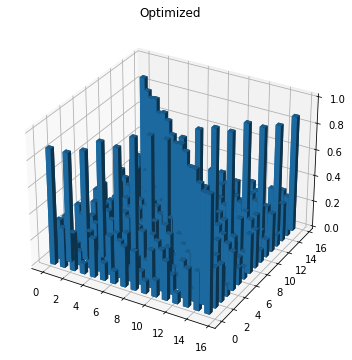

In [42]:
show_perceptron_results(opt_mitigated_result, "Optimized")

In [34]:
get_discrepancy(opt_mitigated_result, ideal_matrix)

0.04534809503637233

[[0.86883349 0.27137898 0.28715683 0.06847586 0.266856   0.09982118
  0.08246555 0.28831387 0.29409908 0.08425371 0.10423898 0.27779531
  0.07194701 0.2910487  0.2690649  0.86315347]
 [0.26327969 0.82823183 0.08509519 0.29157463 0.1158094  0.27527085
  0.27285162 0.09224782 0.09592932 0.2858946  0.27884717 0.11885979
  0.29283686 0.0975071  0.82455033 0.27327233]
 [0.28421163 0.09287893 0.82633849 0.27874201 0.09140633 0.27306195
  0.28652572 0.12064794 0.12033239 0.27411381 0.27884717 0.09245819
  0.2764279  0.81876512 0.09466709 0.28536868]
 [0.07289366 0.29094352 0.28189755 0.87293573 0.29052277 0.08383297
  0.10287157 0.27937309 0.27285157 0.09666561 0.08130855 0.29041759
  0.86325865 0.27179973 0.29367834 0.07268327]
 [0.27800568 0.11843904 0.08888182 0.29041759 0.82339329 0.28410645
  0.27453455 0.08709372 0.08972336 0.26527822 0.28547386 0.82065846
  0.29998948 0.092353   0.12443463 0.26885453]
 [0.09635006 0.26559377 0.29630798 0.07983591 0.26717156 0.86651941
  0.07047436 0.28

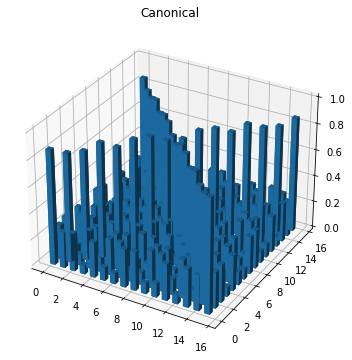

In [43]:
show_perceptron_results(can_mitigated_result, "Canonical")

In [36]:
get_discrepancy(can_mitigated_result, ideal_matrix)

0.031445990658074366

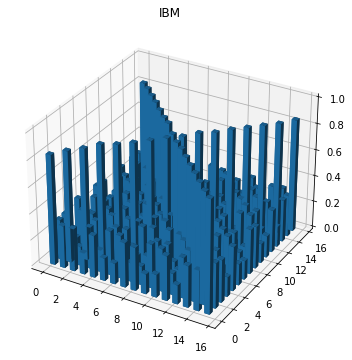

In [37]:
show_perceptron_results(ibm_mitigated_result, "IBM")

In [38]:
get_discrepancy(ibm_mitigated_result, ideal_matrix)

0.07644382414395257